In [11]:
import random

import pandas as pd
import torch
from matplotlib import pyplot as plt
from torch.nn import *
from torch.optim import *

from model import LSTMModel

Read Preprocessed Dataset 

In [12]:
from sklearn.utils import resample

path = './data/final_data.csv'
df = pd.read_csv(path)
# select relevant features
# moods = df[['mood', 'ID']]
# moods = df[['mood', 'ID', 'circumplex.valence',
#        'activity', 'screen', 'call',
#        'appCat.communication',  'appCat.utilities', 'time']]
moods = df[['mood', 'ID', 'circumplex.valence', 'circumplex.arousal', 'time', 'activity', 'appCat.entertainment']]
# process id and mood
moods['time'] = pd.to_datetime(moods['time'])
# moods['time'] = moods['time'].dt.weekday

moods['ID'] = (moods['ID'] - 14) * 100
moods['ID'] = moods['ID'].astype(int)

# 指定日期
specified_date = pd.to_datetime('2014-03-01')

# 计算日期与指定日期之间的天数差
moods['weekday'] = moods['time'].dt.weekday
moods['time'] = (moods['time'] - specified_date).dt.days


moods['mood'] = moods['mood'].apply(lambda x: 0 if x < 4 else (1 if 4 <= x <= 7 else 2))
# Separate majority and minority classes
majority_class = moods[moods['mood'].isin([1, 2])]  # Assuming classes 0 and 1 are the majority classes
minority_class = moods[moods['mood'] == 0]  # Minority class
# Upsample minority class to match the number of majority class samples
minority_upsampled = resample(minority_class, 
                              replace=True,  # Sample with replacement
                              n_samples=len(majority_class)//6,  # Match majority class size
                              random_state=42)  # For reproducibility
moods = pd.concat([majority_class, minority_upsampled])
# moods['mood'] = moods['mood'].round().astype(int)
print(moods['mood'].value_counts())
print(moods)
# print(moods['time'].value_counts())

mood
1    714
2    547
0    210
Name: count, dtype: int64
     mood  ID  circumplex.valence  circumplex.arousal  time  activity  \
0       1   0            0.145647           -0.220617    -3 -0.650267   
1       1   0           -0.813869            0.156768    -2 -0.838609   
2       1   0           -1.120914            0.458676    20  0.194961   
3       1   0           -0.430063            1.062492    21  1.290503   
4       1   0            0.260788            0.458676    22  0.287554   
..    ...  ..                 ...                 ...   ...       ...   
262     0   7           -2.502616           -1.654681    47  0.024933   
262     0   7           -2.502616           -1.654681    47  0.024933   
262     0   7           -2.502616           -1.654681    47  0.024933   
262     0   7           -2.502616           -1.654681    47  0.024933   
270     0   7           -3.116705            0.659948    55 -0.423055   

     appCat.entertainment  weekday  
0               -0.396678   

C:\Users\china\AppData\Local\Temp\ipykernel_15232\3319141681.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moods['time'] = pd.to_datetime(moods['time'])
C:\Users\china\AppData\Local\Temp\ipykernel_15232\3319141681.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moods['ID'] = (moods['ID'] - 14) * 100
C:\Users\china\AppData\Local\Temp\ipykernel_15232\3319141681.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [13]:
random.seed(42)
# define hyper-parameters
hidden_size = 64 # 隐藏层维度
num_layers = 4 # LSTM层数
output_size = 3  # 输出维度
num_epochs =  450 # 迭代次数
learning_rate = 1e-3  # 学习率
max_grad_norm = 10.0

seq_length = 32
batch_size = 64
step = 1
# generate dataset
ids = moods['ID'].unique()
id_moods = []
for uid in ids:
    # uid = uid
    id_mood = moods[moods['ID'] == uid]
    id_moods.append(id_mood)
# remove data that is not continuous
id_moods[0] = id_moods[0][2:]

dataset = []
for id_mood in id_moods:
    id_dataset = [id_mood[i:i + seq_length + 1] for i in range(0, len(id_mood) - seq_length, step)]
    id_dataset = [df.to_numpy() for df in id_dataset]
    dataset += id_dataset

print('dataset size:', len(dataset))
# split it into train set and test set.
random_indices = random.sample(range(len(dataset)), k=int(len(dataset) * 3 / 10))
train_set = []
test_set = []

for i in range(len(dataset)):
    if i in random_indices:
        test_set.append(dataset[i])
    else:
        train_set.append(dataset[i])
# print(train_set)
print('train set size:',len(train_set))
print('test set size:', len(test_set))

random.shuffle(train_set)
random.shuffle(test_set)
X_train = [element[:seq_length] for element in train_set]
y_train = [element[seq_length:][0][:1] for element in train_set]
X_test = [element[:seq_length] for element in test_set]
y_test = [element[seq_length:][0][:1] for element in test_set]

# convert them into Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

dataset size: 701
train set size: 491
test set size: 210


In [14]:
# 定义参数
input_size = X_train.shape[-1]  # 输入维度
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 创建模型并将其移动到设备上
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
# 定义损失函数和优化器
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = RMSprop(model.parameters(), lr=learning_rate)

loss_history = []
test_acc_history = []
train_acc_history = []
batch_num = len(X_train) // batch_size
# 训练模型
for epoch in range(num_epochs):
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size].to(device)
        targets = y_train[i:i + batch_size].to(device)
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze().long())
        total_loss += loss.item()
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        # 剪枝
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        
    total_loss = total_loss / batch_num
    loss_history.append(total_loss)
    if (epoch + 1) % 3 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss:.4f}')
        # 模型评估
        with torch.no_grad():
            correct = 0
            total = 0
            for i in range(0, len(X_test), batch_size):
                inputs = X_test[i:i + batch_size].to(device)
                targets = y_test[i:i + batch_size].to(device)
                targets = targets.transpose(0, 1)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(1)
                correct_matrix = (predicted == targets)
                correct += (predicted == targets).sum().item()
            print(f'Accuracy on test set: {100 * correct / total:.2f}%')
            test_acc_history.append(100 * correct / total)

            correct = 0
            total = 0
            for i in range(0, len(X_train), batch_size):
                inputs = X_train[i:i + batch_size].to(device)
                targets = y_train[i:i + batch_size].to(device)
                targets = targets.transpose(0, 1)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                # print(predicted)
                # print(targets)
                total += targets.size(1)
                correct_matrix = (predicted == targets)
                correct += (predicted == targets).sum().item()
            print(f'Accuracy on train set: {100 * correct / total:.2f}%')
            train_acc_history.append(100 * correct / total)
    

Epoch [3/450], Loss: 1.2466
Accuracy on test set: 35.24%
Accuracy on train set: 41.55%
Epoch [6/450], Loss: 1.1756
Accuracy on test set: 55.24%
Accuracy on train set: 59.47%
Epoch [9/450], Loss: 1.1083
Accuracy on test set: 62.86%
Accuracy on train set: 62.73%
Epoch [12/450], Loss: 1.0452
Accuracy on test set: 65.71%
Accuracy on train set: 67.01%
Epoch [15/450], Loss: 0.9991
Accuracy on test set: 67.14%
Accuracy on train set: 68.84%
Epoch [18/450], Loss: 0.9853
Accuracy on test set: 66.67%
Accuracy on train set: 69.04%
Epoch [21/450], Loss: 0.9761
Accuracy on test set: 66.19%
Accuracy on train set: 69.45%
Epoch [24/450], Loss: 0.9716
Accuracy on test set: 65.71%
Accuracy on train set: 68.23%
Epoch [27/450], Loss: 0.9676
Accuracy on test set: 65.71%
Accuracy on train set: 69.25%
Epoch [30/450], Loss: 0.9711
Accuracy on test set: 66.67%
Accuracy on train set: 69.86%
Epoch [33/450], Loss: 0.9583
Accuracy on test set: 65.71%
Accuracy on train set: 70.06%
Epoch [36/450], Loss: 0.9589
Accura

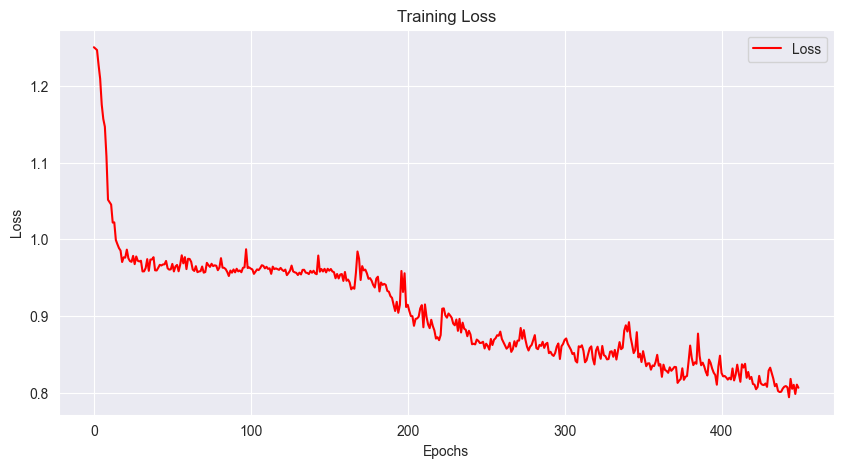

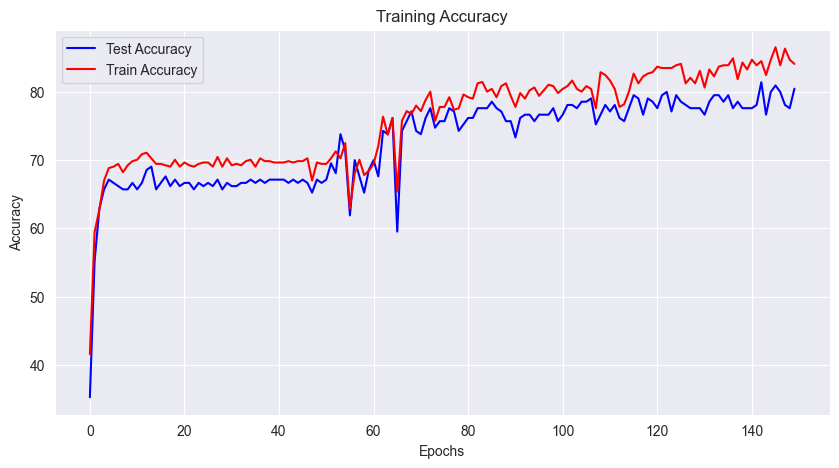

In [15]:
# visualization
plt.figure(figsize=(10, 5))
plt.plot(loss_history, 'r', label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 绘制准确率图像
plt.figure(figsize=(10, 5))
plt.plot(test_acc_history, 'b', label='Test Accuracy')
plt.plot(train_acc_history, 'r', label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
print(f"Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {max(test_acc_history):.2f}%, Train Accuracy: {max(train_acc_history):.2f}%")

Epoch [450/450], Test Accuracy: 81.43%, Train Accuracy: 86.56%
